In [1]:
import IPython
import librosa.display 
import librosa 
import glob
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_validate, KFold, cross_val_score

sr = 44100

## データ読み込み

In [2]:
listMOBI = glob.glob('*mobi.WAV')
wav_listMOBI = sorted(listMOBI) #globはぐちゃぐちゃなので並べる
mobi_list = [i for i in range(11)]
for i in range(11):
    print("・", end="")
    mobi_list[i], sr = librosa.load(wav_listMOBI[i], sr=44100)
print("done!")

・・・・・・・・・・・done!


In [3]:
#import IPython.display
#IPython.display.Audio(wav_listMOBI[10])

In [4]:
g_listA = glob.glob('/Users/tomokijoya/Labolatory/卒論/卒論データ/data_Jan26/a*.wav')
wav_listA = sorted(g_listA) 
g_listT = glob.glob('/Users/tomokijoya/Labolatory/卒論/卒論データ/data_Jan26/t*.wav')
wav_listT = sorted(g_listT) 
g_listJ = glob.glob('/Users/tomokijoya/Labolatory/卒論/卒論データ/data_Jan26/j*.wav')
wav_listJ = sorted(g_listJ) 

Alist = [i for i in range(21)]
print("Arita")
for i in range(21):
    print(".", end="")
    Alist[i], sr = librosa.load(wav_listA[i], sr=44100)
print("")

Tlist = [i for i in range(21)]
print("Tokunaga")
for i in range(21):
    print(".", end="")
    Tlist[i], sr = librosa.load(wav_listT[i], sr=44100)
print("")

Jlist = [i for i in range(21)]
print("Joya")
for i in range(21):
    print(".", end="")
    Jlist[i], sr = librosa.load(wav_listJ[i], sr=44100)
print("")
print("done!")

Arita
.....................
Tokunaga
.....................
Joya
.....................
done!


## 訓練データの整形
とりあえず4秒ずつ

In [86]:
#全体の長さはバラバラで良い
def arangeList4(a_list, total_time, one_time, sr):
    b_list = a_list[:] #スライスを使ってコピー
    for i in range(len(a_list)):
        if total_time*sr < len(a_list[i]):
            left = (len(a_list[i]) - total_time*sr) // 2
            b_list[i] = a_list[i][left :left + total_time*sr]
        
        else:
            b_list[i] = a_list[i][:]
   
    c_list = b_list[:]
    d_list = []
    e_list = []
   
    for l in range(len(c_list)): #サンプルの数
        for k in range(int((len(c_list[l]))//(one_time*sr))): #一つ当たりの数
            x = c_list[l][one_time*sr*k : one_time*sr*(k+1)]
            d_list.append(x)
        e_list.append(d_list)
        d_list = [] #次のループに向けて初期化
    
    return e_list

In [169]:
aranged = arangeList4(mobi_list, 120, 10, sr)
for i in range(11):
    print(len(aranged[i]))

6
12
12
12
12
12
12
12
12
12
12


## 行動ラベルを作成
0: 掃除機 .... 10: 声

In [170]:
label_list = []
for i in range(11):
    tmp = np.full(len(aranged[i]), i)
    label_list = np.append(label_list, tmp)
label_list.shape

(126,)

In [171]:
df_label_train = pd.DataFrame(label_list)
df_label_train.columns = ["action"]
df_label_train

,action
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0
...,...
121,10.0
122,10.0
123,10.0
124,10.0


In [172]:
def makeTokucho_more(a_list):
    sr = 44100
    tokucho1 = [] 
  
    for i in range(len(a_list)): #つまり21or42(iは0~20or41)
        print(i,"回目のループ開始！")
        for j in range(len(a_list[i])): #つまり29
            y = a_list[i][j]
        
            MFCC = librosa.feature.mfcc(y=y, sr=sr)#, frame_length=sr*60)
            FLATNESS = librosa.feature.spectral_flatness(y=y)
            ZCR = librosa.feature.zero_crossing_rate(y=y)#, frame_length=sr)
            CENTROID = librosa.feature.spectral_centroid(y=y, sr=sr)
            RMS = librosa.feature.rms(y=y)#, frame_length=sr)
            ROLLOFF = librosa.feature.spectral_rolloff(y=y, sr=sr, roll_percent=0.95)
            
            
            tokucho_librosa = [np.mean(FLATNESS),np.amax(FLATNESS),np.amin(FLATNESS),np.var(FLATNESS)]
            tokucho_librosa += [np.mean(ZCR),np.amax(ZCR),np.amin(ZCR),np.var(ZCR)]
            tokucho_librosa += [np.mean(CENTROID),np.amax(CENTROID),np.amin(CENTROID),np.var(CENTROID)]
            tokucho_librosa += [np.mean(RMS),np.amax(RMS),np.amin(RMS),np.var(RMS)]
            tokucho_librosa += [np.mean(ROLLOFF),np.amax(ROLLOFF),np.amin(ROLLOFF),np.var(ROLLOFF)]
            
            
            for e in MFCC:
                tokucho_librosa += [np.mean(e),np.amax(e),np.amin(e), np.var(e)]
    
            
            tokucho_librosa.append(0) #ラベル
            
            tokucho1.append(tokucho_librosa)            
            print(".",end="")
        print("")
    
    return tokucho1

In [173]:
#feature = makeTokucho_new(aranged)
feature = makeTokucho_more(aranged)

0 回目のループ開始！
......
1 回目のループ開始！
............
2 回目のループ開始！
............
3 回目のループ開始！
............
4 回目のループ開始！
............
5 回目のループ開始！
............
6 回目のループ開始！
............
7 回目のループ開始！
............
8 回目のループ開始！
............
9 回目のループ開始！
............
10 回目のループ開始！
............


In [174]:
sound_features = ['FLATNESS',
                  'ZCR', 
                  'CENTROID',
                  'RMS',
                  'ROLLOFF',
                  'MFCC']
features = ['mean', 'max', 'min', 'var']

header = ''
for name in sound_features:
    if name != 'MFCC':
        for kind in features:
            header += f" {name}_{kind}" #スペース区切りなのでスペースが大事
    else:
        for mfcc_number in range(1,21):
            for kind in features:
                header += f" {name}{mfcc_number}_{kind}"
            
header += ' label'      #ヘッダーにlabel(ジャンル)をつける=======withなら必要=========
header = header.split() #区切り文字で分割する

In [175]:
len(header)

101

In [176]:
df = pd.DataFrame(feature)
df.columns = header

len_all = len(aranged[0])+len(aranged[1])
len_liv = len(aranged[9])+len(aranged[10])
len_kit = len(aranged[3])+len(aranged[4])+len(aranged[5])+len(aranged[6])+len(aranged[7])+len(aranged[8])
len_bed = len(aranged[2])

df.iloc[:len_all, len(header)-1:] = 3
df.iloc[len_all:len_all+len_bed, len(header)-1:] = 2
df.iloc[len_all+len_bed:len_all+len_bed+len_kit, len(header)-1:] = 1
df.iloc[len_all+len_bed+len_kit:len_all+len_bed+len_kit+len_liv, len(header)-1:] = 0
df

,FLATNESS_mean,FLATNESS_max,FLATNESS_min,FLATNESS_var,ZCR_mean,ZCR_max,ZCR_min,ZCR_var,CENTROID_mean,CENTROID_max,...,MFCC18_var,MFCC19_mean,MFCC19_max,MFCC19_min,MFCC19_var,MFCC20_mean,MFCC20_max,MFCC20_min,MFCC20_var,label
0,0.040715,0.130226,0.007164,0.000381,0.146338,0.270996,0.061035,0.001641,5978.154352,7056.404976,...,24.201870,-0.992385,12.408917,-14.881140,18.993368,10.552118,24.238319,-3.477929,18.032597,3
1,0.044663,0.162874,0.003202,0.000477,0.182719,0.442383,0.009277,0.003979,6187.007176,8025.629980,...,21.014986,1.859270,14.239447,-13.225426,21.887960,11.223223,29.123810,-2.575585,23.932095,3
2,0.051372,0.138668,0.010918,0.000415,0.207729,0.388672,0.077637,0.002723,6332.333621,7393.315702,...,16.981501,0.507616,13.744943,-15.779369,18.634439,9.678190,21.152584,-3.237986,19.182447,3
3,0.039248,0.112485,0.009295,0.000382,0.163881,0.427734,0.069336,0.002651,6034.599744,7434.642289,...,22.289797,1.406943,14.631100,-11.923616,17.247141,10.442810,20.826437,-2.755211,20.621555,3
4,0.063756,0.158518,0.013405,0.000835,0.215463,0.433105,0.080566,0.004592,6754.339799,8047.972582,...,20.879158,0.047482,14.152119,-16.915091,20.075907,8.578962,22.900677,-8.173175,23.798542,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121,0.008231,0.096807,0.000031,0.000222,0.060403,0.359863,0.008301,0.003828,2845.424022,8213.236715,...,53.586926,1.326940,19.367744,-17.712553,42.512264,0.364499,21.427197,-25.968987,52.971359,0
122,0.006171,0.120837,0.000015,0.000170,0.048449,0.367676,0.007812,0.002674,2405.711790,9425.164708,...,38.850502,1.759255,22.106232,-20.607420,53.338284,-0.263788,22.767708,-20.106903,53.501732,0
123,0.007102,0.116279,0.000026,0.000213,0.049973,0.321777,0.006348,0.002405,2549.670330,7465.310081,...,54.458698,1.397281,19.984859,-18.728897,49.067421,0.604797,20.438576,-20.061329,52.249527,0
124,0.005369,0.087394,0.000030,0.000112,0.056970,0.334961,0.011719,0.003274,2630.491051,7455.022270,...,51.680428,-0.020201,22.889042,-21.091190,50.336918,2.352696,23.807785,-17.587128,56.575691,0


In [177]:
df = pd.concat([df, df_label_train], axis=1)
df

,FLATNESS_mean,FLATNESS_max,FLATNESS_min,FLATNESS_var,ZCR_mean,ZCR_max,ZCR_min,ZCR_var,CENTROID_mean,CENTROID_max,...,MFCC19_mean,MFCC19_max,MFCC19_min,MFCC19_var,MFCC20_mean,MFCC20_max,MFCC20_min,MFCC20_var,label,action
0,0.040715,0.130226,0.007164,0.000381,0.146338,0.270996,0.061035,0.001641,5978.154352,7056.404976,...,-0.992385,12.408917,-14.881140,18.993368,10.552118,24.238319,-3.477929,18.032597,3,0.0
1,0.044663,0.162874,0.003202,0.000477,0.182719,0.442383,0.009277,0.003979,6187.007176,8025.629980,...,1.859270,14.239447,-13.225426,21.887960,11.223223,29.123810,-2.575585,23.932095,3,0.0
2,0.051372,0.138668,0.010918,0.000415,0.207729,0.388672,0.077637,0.002723,6332.333621,7393.315702,...,0.507616,13.744943,-15.779369,18.634439,9.678190,21.152584,-3.237986,19.182447,3,0.0
3,0.039248,0.112485,0.009295,0.000382,0.163881,0.427734,0.069336,0.002651,6034.599744,7434.642289,...,1.406943,14.631100,-11.923616,17.247141,10.442810,20.826437,-2.755211,20.621555,3,0.0
4,0.063756,0.158518,0.013405,0.000835,0.215463,0.433105,0.080566,0.004592,6754.339799,8047.972582,...,0.047482,14.152119,-16.915091,20.075907,8.578962,22.900677,-8.173175,23.798542,3,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121,0.008231,0.096807,0.000031,0.000222,0.060403,0.359863,0.008301,0.003828,2845.424022,8213.236715,...,1.326940,19.367744,-17.712553,42.512264,0.364499,21.427197,-25.968987,52.971359,0,10.0
122,0.006171,0.120837,0.000015,0.000170,0.048449,0.367676,0.007812,0.002674,2405.711790,9425.164708,...,1.759255,22.106232,-20.607420,53.338284,-0.263788,22.767708,-20.106903,53.501732,0,10.0
123,0.007102,0.116279,0.000026,0.000213,0.049973,0.321777,0.006348,0.002405,2549.670330,7465.310081,...,1.397281,19.984859,-18.728897,49.067421,0.604797,20.438576,-20.061329,52.249527,0,10.0
124,0.005369,0.087394,0.000030,0.000112,0.056970,0.334961,0.011719,0.003274,2630.491051,7455.022270,...,-0.020201,22.889042,-21.091190,50.336918,2.352696,23.807785,-17.587128,56.575691,0,10.0


In [178]:
print("リビング",len(df[df["label"]==0]))
print("キッチン",len(df[df["label"]==1]))
print("寝室",len(df[df["label"]==2]))
print("その他",len(df[df["label"]==3]))
print("ありえない",len(df[df["label"]==5]))

リビング 24
キッチン 72
寝室 12
その他 18
ありえない 0


## テストデータの整形

In [151]:
def arangeList(a_list, cut_time, total_time, one_time, sampling_rate):
    b_list = a_list[:] #スライスを使ってコピー
    if cut_time != 0:
        for i in range(len(a_list)):
            b_list[i] = a_list[i][cut_time*sampling_rate:-cut_time*sampling_rate] #cut_time秒だけ前後を削除
    else:
        for i in range(len(a_list)):
            b_list[i] = a_list[i][:]
   
    c_list = b_list[:]
    for j in range(len(b_list)):
        c_list[j] = b_list[j][:total_time*sampling_rate] #全体をtotal_time秒にする
        
    d_list = []
    e_list = []
   
    for l in range(len(c_list)): #サンプルの数
        for k in range(int((len(c_list[l]))//(one_time*sampling_rate))): #一つ当たりの数
            x = c_list[l][one_time*sampling_rate*k : one_time*sampling_rate*(k+1)]
            d_list.append(x)
        e_list.append(d_list)
        d_list = [] #次のループに向けて初期化
    
    return e_list

In [152]:
arangedA = arangeList(Alist, 0, 120, 4, sr)
arangedT = arangeList(Tlist, 0, 120, 4, sr)
arangedJ = arangeList(Jlist, 5, 120, 4, sr)

In [153]:
def makeTokucho_more2(a_list):
    tokucho1 = [] 
  
    for i in range(len(a_list)): #つまり21or42(iは0~20or41)
        for j in range(len(a_list[i])): #つまり29
            y = a_list[i][j]
        
            MFCC = librosa.feature.mfcc(y=y, sr=sr)#, frame_length=sr*60)
            FLATNESS = librosa.feature.spectral_flatness(y=y)
            ZCR = librosa.feature.zero_crossing_rate(y=y)#, frame_length=sr)
            CENTROID = librosa.feature.spectral_centroid(y=y, sr=sr)
            RMS = librosa.feature.rms(y=y)#, frame_length=sr)
            ROLLOFF = librosa.feature.spectral_rolloff(y=y, sr=sr, roll_percent=0.95)
            
            
            tokucho_librosa = [np.mean(FLATNESS),np.amax(FLATNESS),np.amin(FLATNESS),np.var(FLATNESS)]
            tokucho_librosa += [np.mean(ZCR),np.amax(ZCR),np.amin(ZCR),np.var(ZCR)]
            tokucho_librosa += [np.mean(CENTROID),np.amax(CENTROID),np.amin(CENTROID),np.var(CENTROID)]
            tokucho_librosa += [np.mean(RMS),np.amax(RMS),np.amin(RMS),np.var(RMS)]
            tokucho_librosa += [np.mean(ROLLOFF),np.amax(ROLLOFF),np.amin(ROLLOFF),np.var(ROLLOFF)]
            
            for e in MFCC:
                tokucho_librosa += [np.mean(e),np.amax(e),np.amin(e), np.var(e)]
            
            tokucho_librosa.append(i % 3) #部屋
            tokucho_librosa.append(0) #正解ラベル
            tokucho_librosa.append(0) #人
            tokucho_librosa.append(i // 3) #行動
            
            
            tokucho1.append(tokucho_librosa)            
        
            print(".", end="")
        print("|", end="")
    
    return tokucho1

In [154]:
A_feature = makeTokucho_more2(arangedA)
T_feature = makeTokucho_more2(arangedT)
J_feature = makeTokucho_more2(arangedJ)

..............................|..............................|..............................|..............................|..............................|..............................|..............................|..............................|..............................|..............................|..............................|..............................|..............................|..............................|..............................|..............................|..............................|..............................|..............................|..............................|..............................|..............................|..............................|..............................|..............................|..............................|..............................|..............................|..............................|..............................|..............................|..............................|........

In [155]:
sound_features = ['FLATNESS',
                  'ZCR', 
                  'CENTROID',
                  'RMS',
                  'ROLLOFF',
                  'MFCC']
features = ['mean', 'max', 'min', 'var']

headerS = ''
for name in sound_features:
    if name != 'MFCC':
        for kind in features:
            headerS += f" {name}_{kind}" #スペース区切りなのでスペースが大事
    else:
        for mfcc_number in range(1,21):
            for kind in features:
                headerS += f" {name}{mfcc_number}_{kind}"
            
headerS += ' room label name action'      #ヘッダーにlabel(ジャンル)をつける=======withなら必要=========
headerS = headerS.split() #区切り文字で分割する
#headerS

In [156]:
df_A = pd.DataFrame(A_feature)
df_T = pd.DataFrame(T_feature)
df_J = pd.DataFrame(J_feature)

df_A.columns = headerS
df_T.columns = headerS
df_J.columns = headerS
#正解のラベル

df_A.iloc[0:90*2,-3] = int(0)
df_A.iloc[90*2:90*5,-3] = int(1)
df_A.iloc[90*5:90*7,-3] = int(2)

df_T.iloc[0:90*2,-3] = int(0)
df_T.iloc[90*2:90*5,-3] = int(1)
df_T.iloc[90*5:90*7,-3] = int(2)

df_J.iloc[0:90*2,-3] = int(0)
df_J.iloc[90*2:90*5,-3] = int(1)
df_J.iloc[90*5:90*7,-3] = int(2)

#人の名前
df_A.iloc[:,-2] = int(7)
df_T.iloc[:,-2] = int(8)
df_J.iloc[:,-2] = int(9)

df_A = df_A[df_A["room"] == df_A["label"]]
df_T = df_T[df_T["room"] == df_T["label"]]
df_J = df_J[df_J["room"] == df_J["label"]]


df_ATJ = pd.concat([df_A, df_T, df_J])
#df_ATJ = df_ATJ.drop("room", axis=1)
df_ATJ

,FLATNESS_mean,FLATNESS_max,FLATNESS_min,FLATNESS_var,ZCR_mean,ZCR_max,ZCR_min,ZCR_var,CENTROID_mean,CENTROID_max,...,MFCC19_min,MFCC19_var,MFCC20_mean,MFCC20_max,MFCC20_min,MFCC20_var,room,label,name,action
0,0.038621,0.115656,0.005106,0.000389,0.095400,0.182617,0.030762,0.000822,5464.967594,7444.722997,...,-10.228254,21.126907,2.315230,14.327990,-13.319393,21.885004,0,0,7,0
1,0.032777,0.131543,0.006234,0.000376,0.090832,0.176758,0.040527,0.000820,5206.366257,7324.614946,...,-20.079771,35.886238,2.216148,15.521725,-12.840643,28.741854,0,0,7,0
2,0.040721,0.196621,0.006098,0.000797,0.091280,0.198730,0.021484,0.001280,6193.536632,8289.421684,...,-8.182537,20.851933,3.293868,15.403501,-12.837837,20.477840,0,0,7,0
3,0.033499,0.135422,0.005985,0.000453,0.084420,0.165527,0.023926,0.000864,5633.598646,7726.261913,...,-8.164485,18.019409,2.034727,13.083357,-10.057770,18.789925,0,0,7,0
4,0.034877,0.150729,0.006371,0.000406,0.090021,0.169922,0.021973,0.000802,5870.099503,7937.782151,...,-9.691799,24.978996,2.374561,13.732134,-14.223821,24.049337,0,0,7,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
625,0.045086,0.123269,0.009316,0.000540,0.102914,0.181152,0.025391,0.000997,7286.623635,8383.856168,...,-7.253102,9.978428,1.866301,11.786640,-8.349493,10.925330,2,2,9,6
626,0.048833,0.127886,0.007744,0.000583,0.108608,0.207031,0.029785,0.001012,7368.514192,8506.519340,...,-7.792486,11.693015,1.759308,12.902467,-6.603588,11.721128,2,2,9,6
627,0.050916,0.136817,0.006240,0.000590,0.113225,0.190430,0.015625,0.000804,7405.828208,8622.941132,...,-7.233616,10.667303,2.206123,12.158447,-8.805048,10.267080,2,2,9,6
628,0.051334,0.132948,0.010540,0.000549,0.115093,0.189941,0.048340,0.000681,7417.653437,8564.619398,...,-7.080170,12.141718,2.407313,12.689843,-6.982146,11.054459,2,2,9,6


In [157]:
df.head()

,FLATNESS_mean,FLATNESS_max,FLATNESS_min,FLATNESS_var,ZCR_mean,ZCR_max,ZCR_min,ZCR_var,CENTROID_mean,CENTROID_max,...,MFCC19_mean,MFCC19_max,MFCC19_min,MFCC19_var,MFCC20_mean,MFCC20_max,MFCC20_min,MFCC20_var,label,action
0,0.040560,0.091494,0.014325,0.000232,0.153439,0.247559,0.075684,0.000958,6015.595363,6652.402636,...,-0.453729,11.332808,-14.881139,18.738853,11.456292,20.817335,0.700206,16.289795,3,0.0
1,0.045242,0.130456,0.007051,0.000559,0.145921,0.270508,0.049316,0.002401,6146.241194,7068.119018,...,-0.686810,12.180732,-12.562790,19.638826,10.924262,24.417992,0.356892,16.816582,3,0.0
2,0.031542,0.110800,0.003467,0.000308,0.128477,0.220215,0.012695,0.001909,5657.924180,7483.917751,...,0.551047,14.906755,-14.080394,33.208023,9.337496,28.688904,-3.751144,28.579334,3,0.0
3,0.055795,0.162499,0.008492,0.000481,0.216504,0.448242,0.067383,0.003544,6551.502203,8094.995898,...,1.905173,13.763195,-10.521370,16.964401,11.655004,23.044151,-1.442354,20.195423,3,0.0
4,0.040400,0.093662,0.011894,0.000280,0.176987,0.393555,0.083984,0.002374,6042.350232,7176.166948,...,0.697614,11.646395,-10.642591,20.025156,11.091665,23.346123,-1.785987,20.850815,3,0.0


In [158]:
df_ATJ.head()

,FLATNESS_mean,FLATNESS_max,FLATNESS_min,FLATNESS_var,ZCR_mean,ZCR_max,ZCR_min,ZCR_var,CENTROID_mean,CENTROID_max,...,MFCC19_min,MFCC19_var,MFCC20_mean,MFCC20_max,MFCC20_min,MFCC20_var,room,label,name,action
0,0.038621,0.115656,0.005106,0.000389,0.095400,0.182617,0.030762,0.000822,5464.967594,7444.722997,...,-10.228254,21.126907,2.315230,14.327990,-13.319393,21.885004,0,0,7,0
1,0.032777,0.131543,0.006234,0.000376,0.090832,0.176758,0.040527,0.000820,5206.366257,7324.614946,...,-20.079771,35.886238,2.216148,15.521725,-12.840643,28.741854,0,0,7,0
2,0.040721,0.196621,0.006098,0.000797,0.091280,0.198730,0.021484,0.001280,6193.536632,8289.421684,...,-8.182537,20.851933,3.293868,15.403501,-12.837837,20.477840,0,0,7,0
3,0.033499,0.135422,0.005985,0.000453,0.084420,0.165527,0.023926,0.000864,5633.598646,7726.261913,...,-8.164485,18.019409,2.034727,13.083357,-10.057770,18.789925,0,0,7,0
4,0.034877,0.150729,0.006371,0.000406,0.090021,0.169922,0.021973,0.000802,5870.099503,7937.782151,...,-9.691799,24.978996,2.374561,13.732134,-14.223821,24.049337,0,0,7,0


## モデル作成と検証

In [159]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(np.array(df.iloc[:, :-2], dtype = float))
y_train = df["label"]
X_test = scaler.fit_transform(np.array(df_ATJ.iloc[:, :-4], dtype = float))
y_test = df_ATJ["label"]
    
print('trainXは'+str(len(X_train)))
print('trainyは'+str(len(y_train)))
print('testXは'+str(len(X_test)))
print('testyは'+str(len(y_test)))

trainXは316
trainyは316
testXは630
testyは630


In [160]:
def kondo1(X_test, y_test, model):
    names = ['living', 'kitchen', 'bedroom', 'other']
    from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
    y_pred = model.predict(X_test)

#最初
    ax1 = plt.subplot()
    cm1 = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm1, annot = True, cmap='Blues', fmt =".0f",ax=ax1,cbar=False,square=True,
               xticklabels=names,
               yticklabels=names)


    from sklearn.metrics import classification_report
    
    print(classification_report(y_test, y_pred, target_names=names))
    #plt.savefig('seaborn_heatmap_living_1.pdf',bbox_inches='tight')

def kondo2(X_test, y_test, model):
    names = ['living', 'kitchen', 'bedroom', 'other']
    from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
    y_pred = model.predict(X_test)


#いじる
    ax2 = plt.subplot()
    cm = confusion_matrix(y_test, y_pred)
    normed_c = (cm.T *100/ cm.astype(np.float).sum(axis=1)).T
    sns.heatmap(normed_c, annot = True, cmap='Blues', fmt =".1f",ax=ax2,cbar=False,square=True,
               xticklabels=names,
               yticklabels=names)
    #plt.savefig('seaborn_heatmap_bedroom_2.pdf',bbox_inches='tight')

In [161]:
from sklearn.svm import SVC
model = SVC(kernel='linear', random_state=None)

model = model.fit(X_train, y_train)

from sklearn.metrics import accuracy_score
# トレーニングデータに対する精度
pred_train = model.predict(X_train)

accuracy_train = accuracy_score(y_train, pred_train)

print('トレーニングデータに対する正解率： %.2f' % accuracy_train)
    
# テストデータに対する精度
pred_test = model.predict(X_test)

accuracy_test = accuracy_score(y_test, pred_test)


print('テストデータに対する正解率： %.2f' % accuracy_test)

トレーニングデータに対する正解率： 1.00
テストデータに対する正解率： 0.66


              precision    recall  f1-score   support

      living       0.71      0.36      0.48       180
     kitchen       0.59      0.76      0.66       270
     bedroom       1.00      0.82      0.90       180
       other       0.00      0.00      0.00         0

    accuracy                           0.66       630
   macro avg       0.57      0.48      0.51       630
weighted avg       0.74      0.66      0.68       630



/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


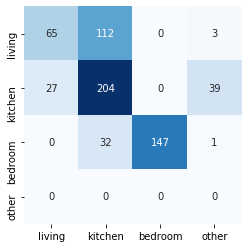

In [162]:
kondo1(X_test, y_test, model)

# 訓練データにかたよりがあるのでどうにかする

In [163]:
print("リビング",len(df[df["label"]==0]))
print("キッチン",len(df[df["label"]==1]))
print("寝室",len(df[df["label"]==2]))
print("その他",len(df[df["label"]==3]))

リビング 60
キッチン 180
寝室 30
その他 46


## ダウンサンプリング
一番ラベルの数が少ないのは2なので、0はliv倍、1はkit倍, 2はbed倍してる。(liv,bedは整数)

In [164]:
from imblearn.under_sampling import RandomUnderSampler

positive_count_train = y_train.value_counts()[2] #リビング=0の数

liv=2
kit=2
bed=1
strategy = {0:positive_count_train*liv, 1:positive_count_train*kit, 2:positive_count_train*bed}

rus = RandomUnderSampler(random_state=77, sampling_strategy = strategy)
X_resampled, y_resampled = rus.fit_resample(X_train, y_train)
y_resampled.value_counts()

1    60
0    60
3    46
2    30
Name: label, dtype: int64

In [165]:
from sklearn.svm import SVC
model2 = SVC(kernel='linear', random_state=None)

model2 = model.fit(X_resampled, y_resampled)

from sklearn.metrics import accuracy_score
# トレーニングデータに対する精度
pred_train = model2.predict(X_train)

accuracy_train = accuracy_score(y_train, pred_train)

print('トレーニングデータに対する正解率： %.2f' % accuracy_train)
    
# テストデータに対する精度
pred_test = model2.predict(X_test)

accuracy_test = accuracy_score(y_test, pred_test)


print('テストデータに対する正解率： %.2f' % accuracy_test)

トレーニングデータに対する正解率： 1.00
テストデータに対する正解率： 0.68


              precision    recall  f1-score   support

      living       0.67      0.43      0.52       180
     kitchen       0.62      0.72      0.66       270
     bedroom       1.00      0.87      0.93       180
       other       0.00      0.00      0.00         0

    accuracy                           0.68       630
   macro avg       0.57      0.50      0.53       630
weighted avg       0.74      0.68      0.70       630



/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


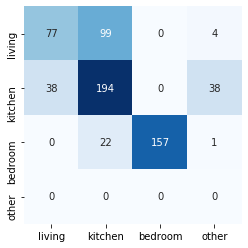

In [166]:
kondo1(X_test, y_test, model2)

## リビングの精度が悪い！
テレビは同じなのにどうして…

## テレビの音声だけでテストしてみる

In [167]:
df_ATJ

,FLATNESS_mean,FLATNESS_max,FLATNESS_min,FLATNESS_var,ZCR_mean,ZCR_max,ZCR_min,ZCR_var,CENTROID_mean,CENTROID_max,...,MFCC19_min,MFCC19_var,MFCC20_mean,MFCC20_max,MFCC20_min,MFCC20_var,room,label,name,action
0,0.038621,0.115656,0.005106,0.000389,0.095400,0.182617,0.030762,0.000822,5464.967594,7444.722997,...,-10.228254,21.126907,2.315230,14.327990,-13.319393,21.885004,0,0,7,0
1,0.032777,0.131543,0.006234,0.000376,0.090832,0.176758,0.040527,0.000820,5206.366257,7324.614946,...,-20.079771,35.886238,2.216148,15.521725,-12.840643,28.741854,0,0,7,0
2,0.040721,0.196621,0.006098,0.000797,0.091280,0.198730,0.021484,0.001280,6193.536632,8289.421684,...,-8.182537,20.851933,3.293868,15.403501,-12.837837,20.477840,0,0,7,0
3,0.033499,0.135422,0.005985,0.000453,0.084420,0.165527,0.023926,0.000864,5633.598646,7726.261913,...,-8.164485,18.019409,2.034727,13.083357,-10.057770,18.789925,0,0,7,0
4,0.034877,0.150729,0.006371,0.000406,0.090021,0.169922,0.021973,0.000802,5870.099503,7937.782151,...,-9.691799,24.978996,2.374561,13.732134,-14.223821,24.049337,0,0,7,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
625,0.045086,0.123269,0.009316,0.000540,0.102914,0.181152,0.025391,0.000997,7286.623635,8383.856168,...,-7.253102,9.978428,1.866301,11.786640,-8.349493,10.925330,2,2,9,6
626,0.048833,0.127886,0.007744,0.000583,0.108608,0.207031,0.029785,0.001012,7368.514192,8506.519340,...,-7.792486,11.693015,1.759308,12.902467,-6.603588,11.721128,2,2,9,6
627,0.050916,0.136817,0.006240,0.000590,0.113225,0.190430,0.015625,0.000804,7405.828208,8622.941132,...,-7.233616,10.667303,2.206123,12.158447,-8.805048,10.267080,2,2,9,6
628,0.051334,0.132948,0.010540,0.000549,0.115093,0.189941,0.048340,0.000681,7417.653437,8564.619398,...,-7.080170,12.141718,2.407313,12.689843,-6.982146,11.054459,2,2,9,6


In [168]:
df_ATJ_nonVoice = df_ATJ[df_ATJ["action"] != 1]
df_ATJ_nonVoice

,FLATNESS_mean,FLATNESS_max,FLATNESS_min,FLATNESS_var,ZCR_mean,ZCR_max,ZCR_min,ZCR_var,CENTROID_mean,CENTROID_max,...,MFCC19_min,MFCC19_var,MFCC20_mean,MFCC20_max,MFCC20_min,MFCC20_var,room,label,name,action
0,0.038621,0.115656,0.005106,0.000389,0.095400,0.182617,0.030762,0.000822,5464.967594,7444.722997,...,-10.228254,21.126907,2.315230,14.327990,-13.319393,21.885004,0,0,7,0
1,0.032777,0.131543,0.006234,0.000376,0.090832,0.176758,0.040527,0.000820,5206.366257,7324.614946,...,-20.079771,35.886238,2.216148,15.521725,-12.840643,28.741854,0,0,7,0
2,0.040721,0.196621,0.006098,0.000797,0.091280,0.198730,0.021484,0.001280,6193.536632,8289.421684,...,-8.182537,20.851933,3.293868,15.403501,-12.837837,20.477840,0,0,7,0
3,0.033499,0.135422,0.005985,0.000453,0.084420,0.165527,0.023926,0.000864,5633.598646,7726.261913,...,-8.164485,18.019409,2.034727,13.083357,-10.057770,18.789925,0,0,7,0
4,0.034877,0.150729,0.006371,0.000406,0.090021,0.169922,0.021973,0.000802,5870.099503,7937.782151,...,-9.691799,24.978996,2.374561,13.732134,-14.223821,24.049337,0,0,7,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
625,0.045086,0.123269,0.009316,0.000540,0.102914,0.181152,0.025391,0.000997,7286.623635,8383.856168,...,-7.253102,9.978428,1.866301,11.786640,-8.349493,10.925330,2,2,9,6
626,0.048833,0.127886,0.007744,0.000583,0.108608,0.207031,0.029785,0.001012,7368.514192,8506.519340,...,-7.792486,11.693015,1.759308,12.902467,-6.603588,11.721128,2,2,9,6
627,0.050916,0.136817,0.006240,0.000590,0.113225,0.190430,0.015625,0.000804,7405.828208,8622.941132,...,-7.233616,10.667303,2.206123,12.158447,-8.805048,10.267080,2,2,9,6
628,0.051334,0.132948,0.010540,0.000549,0.115093,0.189941,0.048340,0.000681,7417.653437,8564.619398,...,-7.080170,12.141718,2.407313,12.689843,-6.982146,11.054459,2,2,9,6


In [123]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(np.array(df.iloc[:, :-2], dtype = float))
y_train = df["label"]
X_test = scaler.fit_transform(np.array(df_ATJ_nonVoice.iloc[:, :-4], dtype = float))
y_test = df_ATJ_nonVoice["label"]
    
print('trainXは'+str(len(X_train)))
print('trainyは'+str(len(y_train)))
print('testXは'+str(len(X_test)))
print('testyは'+str(len(y_test)))

trainXは316
trainyは316
testXは540
testyは540


In [124]:
from sklearn.svm import SVC
model = SVC(kernel='linear', random_state=None)

model = model.fit(X_train, y_train)

from sklearn.metrics import accuracy_score
# トレーニングデータに対する精度
pred_train = model.predict(X_train)

accuracy_train = accuracy_score(y_train, pred_train)

print('トレーニングデータに対する正解率： %.2f' % accuracy_train)
    
# テストデータに対する精度
pred_test = model.predict(X_test)

accuracy_test = accuracy_score(y_test, pred_test)


print('テストデータに対する正解率： %.2f' % accuracy_test)

トレーニングデータに対する正解率： 1.00
テストデータに対する正解率： 0.64


              precision    recall  f1-score   support

      living       0.17      0.14      0.15        90
     kitchen       0.64      0.69      0.67       270
     bedroom       1.00      0.82      0.90       180
       other       0.00      0.00      0.00         0

    accuracy                           0.64       540
   macro avg       0.45      0.41      0.43       540
weighted avg       0.68      0.64      0.66       540



/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


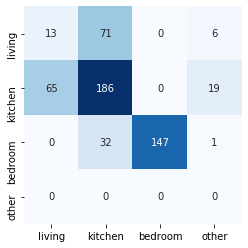

In [125]:
kondo1(X_test, y_test, model)

### テレビをテレビと認識しない…

In [126]:
df_ATJ_nonTV = df_ATJ[df_ATJ["action"] != 0]
#df_ATJ_nonTV

In [127]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(np.array(df.iloc[:, :-2], dtype = float))
y_train = df["label"]
X_test = scaler.fit_transform(np.array(df_ATJ_nonTV.iloc[:, :-4], dtype = float))
y_test = df_ATJ_nonTV["label"]
    
print('trainXは'+str(len(X_train)))
print('trainyは'+str(len(y_train)))
print('testXは'+str(len(X_test)))
print('testyは'+str(len(y_test)))

trainXは316
trainyは316
testXは540
testyは540


In [128]:
from sklearn.svm import SVC
model = SVC(kernel='linear', random_state=None)

model = model.fit(X_train, y_train)

from sklearn.metrics import accuracy_score
# トレーニングデータに対する精度
pred_train = model.predict(X_train)

accuracy_train = accuracy_score(y_train, pred_train)

print('トレーニングデータに対する正解率： %.2f' % accuracy_train)
    
# テストデータに対する精度
pred_test = model.predict(X_test)

accuracy_test = accuracy_score(y_test, pred_test)


print('テストデータに対する正解率： %.2f' % accuracy_test)

トレーニングデータに対する正解率： 1.00
テストデータに対する正解率： 0.82


              precision    recall  f1-score   support

      living       0.72      0.80      0.76        90
     kitchen       0.84      0.80      0.82       270
     bedroom       1.00      0.86      0.92       180
       other       0.00      0.00      0.00         0

    accuracy                           0.82       540
   macro avg       0.64      0.61      0.62       540
weighted avg       0.87      0.82      0.84       540



/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


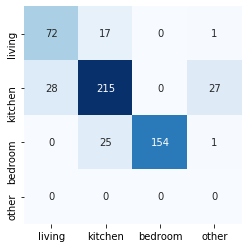

In [129]:
kondo1(X_test, y_test, model)